In [2]:
import scipy.io as sio
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import signal
import seaborn as sns
from scipy.integrate import simps
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix
from scipy import signal
from sklearn.pipeline import Pipeline
from scipy.signal import butter, filtfilt, iirnotch
import pywt


In [3]:
# preprocess data
def butterworth_filter(data, order, cutoff_freq, fs):
    nyquist_freq = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data, axis=1)
    return filtered_data

def notch_filter(data, notch_freq, q_factor, fs):
    b, a = iirnotch(notch_freq, q_factor, fs=fs)
    filtered_data = filtfilt(b, a, data, axis=1)
    return filtered_data

def high_pass_filter(data, order, cutoff_freq, sampling_rate):
    nyquist_freq = 0.5 * sampling_rate
    normalized_cutoff_freq = cutoff_freq / nyquist_freq
    b, a = butter(order, normalized_cutoff_freq, btype='high', analog=False, output='ba')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def lineaer_interpolation(eeg_data):
    missing_indices = np.where(np.isnan(eeg_data))[0]
# Perform linear interpolation
    for index in missing_indices:
        previous_index = index - 1
        next_index = index + 1
        # Find the previous and next non-missing values
        while np.isnan(eeg_data[previous_index]):
            previous_index -= 1
        while np.isnan(eeg_data[next_index]):
            next_index += 1
        # Perform linear interpolation
        eeg_data[index] = (eeg_data[previous_index] + eeg_data[next_index]) / 2
    return eeg_data

def preprocess_data(eeg_data):
    fs = 256  # Sampling frequency
    order = 6  # Filter order
    cutoff_freq_low = 80  # Cutoff frequency for low pass
    cutoff_freq_high = 0.5  # Cutoff frequency for high pass
    notch_freq = 50  # Notch frequency
    q_factor = 30  # Quality factor
    filtered_data = butterworth_filter(eeg_data, order, cutoff_freq_low, fs)
    filtered_data_high = high_pass_filter(filtered_data, order, cutoff_freq_high, fs)
    notch_filtered_data = notch_filter(filtered_data_high, notch_freq, q_factor, fs)
    eeg_scaled = notch_filtered_data*1.2
    eeg_interpolated = lineaer_interpolation(eeg_scaled)
    return eeg_interpolated

In [4]:
sig_1hz_before_coffee = []
sig_1hz_after_coffee = []
sig_5hz_before_coffee = []
sig_5hz_after_coffee = []
sig_10hz_before_coffee = []
sig_10hz_after_coffee = []
sig_15hz_before_coffee = []
sig_15hz_after_coffee = []
sig_20hz_before_coffee = []
sig_20hz_after_coffee = []
sig_25hz_before_coffee = []
sig_25hz_after_coffee = []
sig_30hz_before_coffee = []
sig_30hz_after_coffee = []

volunteers = ["1", "2", "3", "4", "5", "6"]
labels = ["A", "B"]

data_labels = []

# before coffee
for volunteer in volunteers:
    label = "B" # B = before coffee

    file_name = volunteer + "_" + label + ".mat"

    mat = sio.loadmat(file_name)
    mat = mat["ssvep"]

    data = []

    for stimuli in mat:
        stimuli_name = stimuli[1][0]
        stimuli_data = np.array(stimuli[0])
        stimuli_data = np.delete(stimuli_data, -1, axis=1)

        # preprocess data
        stimuli_data = preprocess_data(stimuli_data)

        if stimuli_name == "sig1Hz":
            sig_1hz_before_coffee.append(stimuli_data)
        elif stimuli_name == "sig5Hz":
            sig_5hz_before_coffee.append(stimuli_data)
        elif stimuli_name == "sig10Hz":
            sig_10hz_before_coffee.append(stimuli_data)
        elif stimuli_name == "sig15Hz":
            sig_15hz_before_coffee.append(stimuli_data)
        elif stimuli_name == "sig20Hz":
            sig_20hz_before_coffee.append(stimuli_data)
        elif stimuli_name == "sig25Hz":
            sig_25hz_before_coffee.append(stimuli_data)
        elif stimuli_name == "sig30Hz":
            sig_30hz_before_coffee.append(stimuli_data)

# after coffee
for volunteer in volunteers:
    label = "A" # A = after coffee

    file_name = volunteer + "_" + label + ".mat"

    mat = sio.loadmat(file_name)
    mat = mat["ssvep"]

    data = []

    for stimuli in mat:
        stimuli_name = stimuli[1][0]
        stimuli_data = np.array(stimuli[0])
        stimuli_data = np.delete(stimuli_data, -1, axis=1)

        # preprocess data
        stimuli_data = preprocess_data(stimuli_data)

        if stimuli_name == "sig1Hz":
            sig_1hz_after_coffee.append(stimuli_data)
        elif stimuli_name == "sig5Hz":
            sig_5hz_after_coffee.append(stimuli_data)
        elif stimuli_name == "sig10Hz":
            sig_10hz_after_coffee.append(stimuli_data)
        elif stimuli_name == "sig15Hz":
            sig_15hz_after_coffee.append(stimuli_data)
        elif stimuli_name == "sig20Hz":
            sig_20hz_after_coffee.append(stimuli_data)
        elif stimuli_name == "sig25Hz":
            sig_25hz_after_coffee.append(stimuli_data)
        elif stimuli_name == "sig30Hz":
            sig_30hz_after_coffee.append(stimuli_data)

In [5]:
epoch_length = 4  # Length of each epoch in seconds
sampling_rate = 256  # EEG sampling rate in Hz

epoch_samples = epoch_length * sampling_rate

# Splitting signals into epochs before coffee
sig_1hz_before_coffee_epochs = []
for sig in sig_1hz_before_coffee:
    num_epochs = sig.shape[0] // epoch_samples
    sig_epochs = np.split(sig[:num_epochs * epoch_samples], num_epochs)
    sig_1hz_before_coffee_epochs.extend(sig_epochs)

sig_5hz_before_coffee_epochs = []
for sig in sig_5hz_before_coffee:
    num_epochs = sig.shape[0] // epoch_samples
    sig_epochs = np.split(sig[:num_epochs * epoch_samples], num_epochs)
    sig_5hz_before_coffee_epochs.extend(sig_epochs)

sig_10hz_before_coffee_epochs = []
for sig in sig_10hz_before_coffee:
    num_epochs = sig.shape[0] // epoch_samples
    sig_epochs = np.split(sig[:num_epochs * epoch_samples], num_epochs)
    sig_10hz_before_coffee_epochs.extend(sig_epochs)

sig_15hz_before_coffee_epochs = []
for sig in sig_15hz_before_coffee:
    num_epochs = sig.shape[0] // epoch_samples
    sig_epochs = np.split(sig[:num_epochs * epoch_samples], num_epochs)
    sig_15hz_before_coffee_epochs.extend(sig_epochs)

sig_20hz_before_coffee_epochs = []
for sig in sig_20hz_before_coffee:
    num_epochs = sig.shape[0] // epoch_samples
    sig_epochs = np.split(sig[:num_epochs * epoch_samples], num_epochs)
    sig_20hz_before_coffee_epochs.extend(sig_epochs)

sig_25hz_before_coffee_epochs = []
for sig in sig_25hz_before_coffee:
    num_epochs = sig.shape[0] // epoch_samples
    sig_epochs = np.split(sig[:num_epochs * epoch_samples], num_epochs)
    sig_25hz_before_coffee_epochs.extend(sig_epochs)

sig_30hz_before_coffee_epochs = []
for sig in sig_30hz_before_coffee:
    num_epochs = sig.shape[0] // epoch_samples
    sig_epochs = np.split(sig[:num_epochs * epoch_samples], num_epochs)
    sig_30hz_before_coffee_epochs.extend(sig_epochs)

# Splitting signals into epochs after coffee
sig_1hz_after_coffee_epochs = []
for sig in sig_1hz_after_coffee:
    num_epochs = sig.shape[0] // epoch_samples
    sig_epochs = np.split(sig[:num_epochs * epoch_samples], num_epochs)
    sig_1hz_after_coffee_epochs.extend(sig_epochs)

sig_5hz_after_coffee_epochs = []
for sig in sig_5hz_after_coffee:
    num_epochs = sig.shape[0] // epoch_samples
    sig_epochs = np.split(sig[:num_epochs * epoch_samples], num_epochs)
    sig_5hz_after_coffee_epochs.extend(sig_epochs)

sig_10hz_after_coffee_epochs = []
for sig in sig_10hz_after_coffee:
    num_epochs = sig.shape[0] // epoch_samples
    sig_epochs = np.split(sig[:num_epochs * epoch_samples], num_epochs)
    sig_10hz_after_coffee_epochs.extend(sig_epochs)

sig_15hz_after_coffee_epochs = []
for sig in sig_15hz_after_coffee:
    num_epochs = sig.shape[0] // epoch_samples
    sig_epochs = np.split(sig[:num_epochs * epoch_samples], num_epochs)
    sig_15hz_after_coffee_epochs.extend(sig_epochs)

sig_20hz_after_coffee_epochs = []
for sig in sig_20hz_after_coffee:
    num_epochs = sig.shape[0] // epoch_samples
    sig_epochs = np.split(sig[:num_epochs * epoch_samples], num_epochs)
    sig_20hz_after_coffee_epochs.extend(sig_epochs)

sig_25hz_after_coffee_epochs = []
for sig in sig_25hz_after_coffee:
    num_epochs = sig.shape[0] // epoch_samples
    sig_epochs = np.split(sig[:num_epochs * epoch_samples], num_epochs)
    sig_25hz_after_coffee_epochs.extend(sig_epochs)

sig_30hz_after_coffee_epochs = []
for sig in sig_30hz_after_coffee:
    num_epochs = sig.shape[0] // epoch_samples
    sig_epochs = np.split(sig[:num_epochs * epoch_samples], num_epochs)
    sig_30hz_after_coffee_epochs.extend(sig_epochs)

In [17]:
no_process = sig_1hz_after_coffee[0][:,0]
no_process.shape

(5120,)

In [73]:
yes_process = sig_1hz_after_coffee[0][:,0]

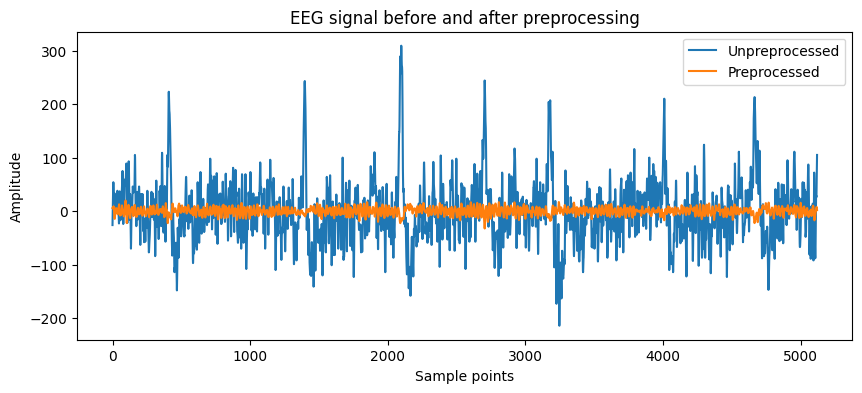

In [151]:
plt.figure(figsize=(10,4))
plt.plot(no_process, label='Unpreprocessed')
plt.plot(yes_process, label='Preprocessed')

plt.xlabel('Sample points')
plt.ylabel('Amplitude')
plt.title('EEG signal before and after preprocessing')
plt.legend()
plt.show()

In [122]:
np.array(sig_1hz_before_coffee_epochs).shape

(30, 1024, 22)

Text(0.5, 1.0, 'One epoch')

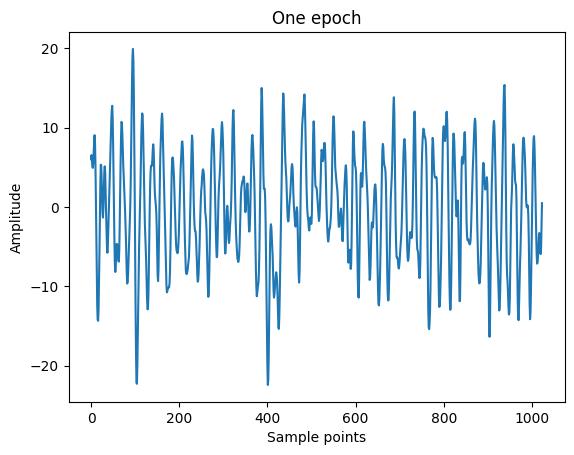

In [153]:
yes_epoch = sig_1hz_after_coffee_epochs[0][:,0]
plt.plot(yes_epoch)
plt.xlabel('Sample points')
plt.ylabel('Amplitude')
plt.title('One epoch')

In [6]:
import csv
diff = ((np.array(sig_1hz_after_coffee) - np.array(sig_1hz_before_coffee))/np.array(sig_1hz_before_coffee))*100
# print(diff)

reshaped_vector = np.reshape(diff, (6 * 5120, 22))

# Define the filename for the CSV file
filename = "difference_vector.csv"

# Save the reshaped vector to the CSV file
with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(reshaped_vector)

<Figure size 1500x400 with 0 Axes>

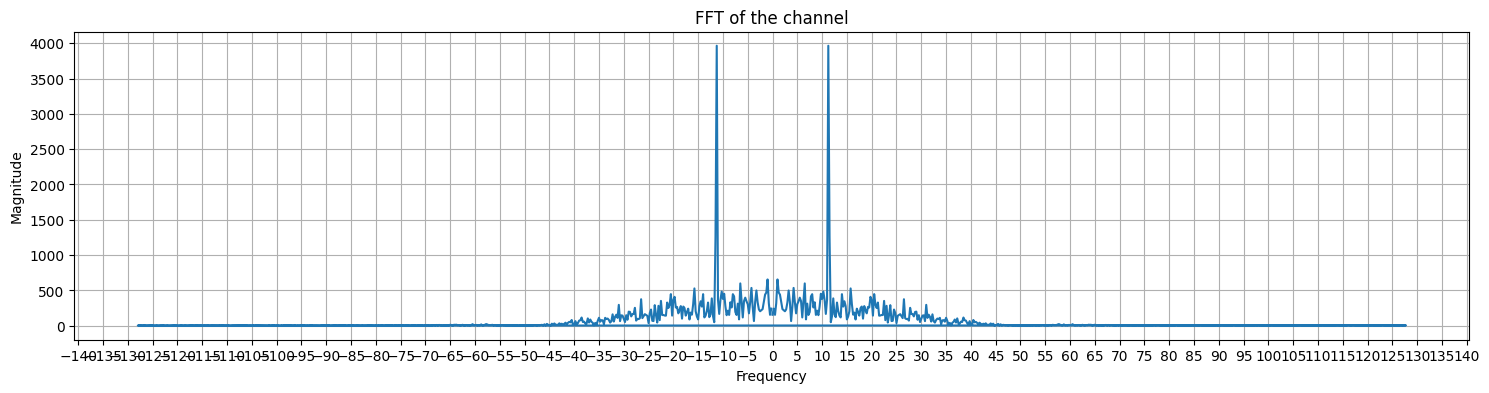

In [188]:
v1_a = sig_1hz_after_coffee_epochs[0].transpose()
# Select the first line of the signal
line = v1_a[0, :]
# Apply FFT to the selected line
fft_result = np.fft.fft(line)
import matplotlib.ticker as ticker

# Calculate the frequency axis
sampling_freq = 256  
freq_axis = np.fft.fftfreq(line.shape[0], 1 / sampling_freq)
plt.figure(figsize=(15, 4))
# Plot the FFT result
fig, ax = plt.subplots(1, 1, figsize=(18,4))
space = 5
ax.plot(freq_axis, np.abs(fft_result))
plt.xlabel('Frequency')
ax.xaxis.set_major_locator(ticker.MultipleLocator(space))
plt.ylabel('Magnitude')
plt.title('FFT of the channel')
plt.grid(True)
plt.show()

In [288]:
def mean(x):
    return np.array(np.mean(x))

def std(x):
    return np.array(np.std(x))

def ptp(x):
    return np.array(np.ptp(x))

def var(x):
    return np.array(np.var(x))

def minim(x):
    return np.array(np.min(x))

def maxim(x):
    return np.array(np.max(x))

def argminim(x):
    return np.array(np.argmin(x))

def argmaxim(x):
    return np.array(np.argmax(x))

def abs_diff_signal(x):
    return np.array(np.sum(np.abs(np.diff(x)),axis=-1))

def skewness(x):
    return np.array(stats.skew(x))

def kurtosis(x):
    return np.array(stats.kurtosis(x,axis=-1))

def signal_energy(signal):
    signal = np.asarray(signal)
    energy = np.sum(np.square(signal))
    return energy

def spectral_entropy(x):
    f, Pxx = signal.welch(x, fs=256, nperseg=128, noverlap=None)
    normalized_Pxx = Pxx / np.sum(Pxx)  # Normalize the power spectrum
    entropy = -np.sum(normalized_Pxx * np.log2(normalized_Pxx))
    return entropy

def wavelet_features(signal):
    wavelet='db4'
    levels=4
    coeffs = pywt.wavedec(signal, wavelet, level=levels)
    features = np.hstack(coeffs)
    return features

def concatenate_features(x):
    return np.hstack((mean(x), std(x), ptp(x), var(x), minim(x), maxim(x), argminim(x), 
                           argmaxim(x), abs_diff_signal(x), skewness(x), kurtosis(x), signal_energy(x), spectral_entropy(x), wavelet_features(x)))

In [289]:
def extract_features(x):
# receives a (1024, 22) matrix which represents 22 channels of 1024 samples each
# returns a (1, 264) matrix which represents 22 channels of 12 features each
    x = np.transpose(x)
    # print(x)
    output = []
    for channel in x:
        # print(concatenate_features(channel).shape)
        output.append(concatenate_features(channel))
    return(np.array(np.hstack(output))) 

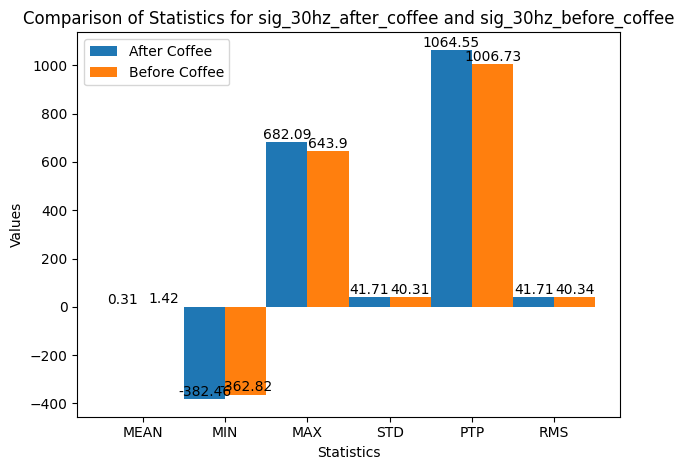

In [135]:
# Function definitions
def mean(x):
    return np.mean(x)

def minim(x):
    return np.min(x)

def maxim(x):
    return np.max(x)

def std(x):
    return np.std(x)

def ptp(x):
    return np.ptp(x)

def rms(x):
    return np.sqrt(np.mean(np.square(x)))

# Calculate the values for sig_5Hz_after_coffee
MEAN_after = mean(sig_30hz_after_coffee)
MIN_after = minim(sig_30hz_after_coffee)
MAX_after = maxim(sig_30hz_after_coffee)
STD_after = std(sig_30hz_after_coffee)
PTP_after = ptp(sig_30hz_after_coffee)
RMS_after = rms(sig_30hz_after_coffee)

# Calculate the values for sig_30hz_before_coffee
MEAN_before = mean(sig_30hz_before_coffee)
MIN_before = minim(sig_30hz_before_coffee)
MAX_before = maxim(sig_30hz_before_coffee)
STD_before = std(sig_30hz_before_coffee)
PTP_before = ptp(sig_30hz_before_coffee)
RMS_before = rms(sig_30hz_before_coffee)


# Plot the values
labels = ['MEAN', 'MIN', 'MAX', 'STD', 'PTP', 'RMS']
values_after = [MEAN_after, MIN_after, MAX_after, STD_after, PTP_after, RMS_after]
values_before = [MEAN_before, MIN_before, MAX_before, STD_before, PTP_before, RMS_before]
bar_width = 0.5
x_pos = np.arange(len(labels))

plt.bar(x_pos, values_after, width=bar_width, label='After Coffee')
plt.bar(x_pos + bar_width, values_before, width=bar_width, label='Before Coffee')

# Add the values on top of the bars with adjusted positioning
for i, v in enumerate(values_after):
    plt.text(i, v + 0.3, f"{float(round(v, 2))}", ha='center', va='bottom')
    
for i, v in enumerate(values_before):
    plt.text(i + bar_width, v + 0.3, f"{float(round(v, 2))}", ha='center', va='bottom')

plt.xlabel('Statistics')
plt.ylabel('Values')
plt.title('Comparison of Statistics for sig_30hz_after_coffee and sig_30hz_before_coffee')
plt.xticks(x_pos + bar_width / 2, labels)
plt.legend()
plt.tight_layout()
plt.show()

In [281]:
def get_X_Y(before, after):

    b = np.array(before)
    a = np.array(after)

    # a and b have the same shape (6, 5120, 22)

    # combine all 6 volunteers into one matrix (5120 * 6, 22)
    b_out = np.reshape(b, (b.shape[0] * b.shape[1], b.shape[2]))
    a_out = np.reshape(a, (a.shape[0] * a.shape[1], a.shape[2]))

    # # split 30720 rows into 30 chunks of 1024 rows
    # b_out = np.split(b_out, 30)
    # a_out = np.split(a_out, 30)

    # extract features from each chunk
    b_out = [extract_features(x) for x in b_out]
    a_out = [extract_features(x) for x in a_out]

    X = np.vstack((b_out, a_out))
    Y = np.array([0] * 30 + [1] * 30)

    return X, Y

In [290]:
def get_accuracy_for_SVM(before, after):
    X, Y = get_X_Y(before, after)

    param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
    svm = SVC()
    kfold = StratifiedKFold(n_splits=2, shuffle=True)
    grid_search = GridSearchCV(svm, param_grid, cv=kfold)
    grid_search.fit(X, Y)

    # Retrieve the best hyperparameters
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)

    # Extract the best hyperparameters
    best_C = best_params['C']
    best_kernel = best_params['kernel']

    # Train the SVM model with the best hyperparameters
    svm_best = SVC(C=best_C, kernel=best_kernel)
    svm_best.fit(X, Y)
    print("Best Classifier:", svm_best)

    # Perform cross-validation to obtain accuracy scores
    cv_scores = cross_val_score(svm_best, X, Y, cv=kfold, scoring='f1_macro')

    # Calculate the average accuracy
    average_accuracy = cv_scores.mean()
    print("Accuracies: ", cv_scores)
    print("Average Accuracy: ", average_accuracy)

    return average_accuracy

In [198]:
np.array(sig_1hz_before_coffee_epochs).shape

(30, 1024, 22)

In [291]:
from sklearn.metrics import classification_report 
def svm_classification(before, after):
    # Split the data into training and testing sets
    X,Y = get_X_Y(before, after)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

    # Create an SVM classifier
    svm = SVC()

    # Train the SVM classifier
    svm.fit(X_train, Y_train)

    # Predict the labels for the test set
    Y_pred = svm.predict(X_test)

    # Generate a classification report
    report = classification_report(Y_test, Y_pred)

    return report

In [293]:
acc = svm_classification(sig_1hz_before_coffee_epochs, sig_1hz_after_coffee_epochs)
acc

'              precision    recall  f1-score   support\n\n           0       0.75      0.43      0.55         7\n           1       0.50      0.80      0.62         5\n\n    accuracy                           0.58        12\n   macro avg       0.62      0.61      0.58        12\nweighted avg       0.65      0.58      0.57        12\n'

Best Hyperparameters: {'C': 10, 'kernel': 'sigmoid'}
Best Classifier: SVC(C=10, kernel='sigmoid')
Accuracies:  [0.53333333 0.59276018]
Average Accuracy:  0.5630467571644042
Best Hyperparameters: {'C': 0.1, 'kernel': 'linear'}
Best Classifier: SVC(C=0.1, kernel='linear')
Accuracies:  [0.61222092 0.56618465]
Average Accuracy:  0.5892027830897106
Best Hyperparameters: {'C': 0.1, 'kernel': 'linear'}
Best Classifier: SVC(C=0.1, kernel='linear')
Accuracies:  [0.53333333 0.30555556]
Average Accuracy:  0.41944444444444445
Best Hyperparameters: {'C': 10, 'kernel': 'sigmoid'}
Best Classifier: SVC(C=10, kernel='sigmoid')
Accuracies:  [0.53125    0.66517857]
Average Accuracy:  0.5982142857142857
Best Hyperparameters: {'C': 10, 'kernel': 'rbf'}
Best Classifier: SVC(C=10)
Accuracies:  [0.61222092 0.40340909]
Average Accuracy:  0.5078150037389169
Best Hyperparameters: {'C': 0.1, 'kernel': 'linear'}
Best Classifier: SVC(C=0.1, kernel='linear')
Accuracies:  [0.4        0.49494949]
Average Accuracy:  0.

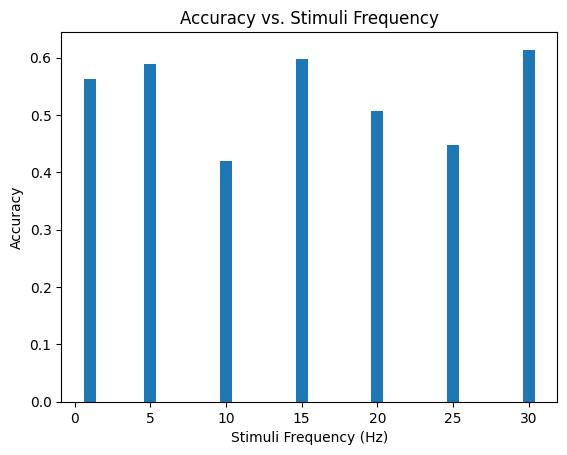

In [294]:
accuracy_1hz = get_accuracy_for_SVM(sig_1hz_before_coffee_epochs, sig_1hz_after_coffee_epochs)
accuracy_5hz = get_accuracy_for_SVM(sig_5hz_before_coffee_epochs, sig_5hz_after_coffee_epochs)
accuracy_10hz = get_accuracy_for_SVM(sig_10hz_before_coffee_epochs, sig_10hz_after_coffee_epochs)
accuracy_15hz = get_accuracy_for_SVM(sig_15hz_before_coffee_epochs, sig_15hz_after_coffee_epochs)
accuracy_20hz = get_accuracy_for_SVM(sig_20hz_before_coffee_epochs, sig_20hz_after_coffee_epochs)
accuracy_25hz = get_accuracy_for_SVM(sig_25hz_before_coffee_epochs, sig_25hz_after_coffee_epochs)
accuracy_30hz = get_accuracy_for_SVM(sig_30hz_before_coffee_epochs, sig_30hz_after_coffee_epochs)


# plot results
x = [1, 5, 10, 15, 20, 25, 30]
y = [accuracy_1hz, accuracy_5hz, accuracy_10hz, accuracy_15hz, accuracy_20hz, accuracy_25hz, accuracy_30hz]
mean_acc = np.mean(y)
print("Mean accuracy: ", mean_acc)
plt.bar(x, y)
plt.xlabel("Stimuli Frequency (Hz)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Stimuli Frequency")
plt.show()

In [295]:
from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
class EEGkNNClassifier:
    def __init__(self, k):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        y_pred = []
        for x in X_test:
            # Calculate distances between the test sample and all training samples
            distances = [euclidean(x, x_train) for x_train in self.X_train]
            # Sort distances and get indices of k nearest neighbors
            indices = np.argsort(distances)[:self.k]
            # Get the labels of the k nearest neighbors
            labels = self.y_train[indices]
            # Predict the label by majority voting
            y_pred.append(np.bincount(labels).argmax())
        return np.array(y_pred)

   
X, y = get_X_Y(sig_15hz_before_coffee_epochs, sig_15hz_after_coffee_epochs)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
   
# Create and train the EEG kNN classifier
k = 7  # number of nearest neighbors
eeg_classifier = EEGkNNClassifier(k)
eeg_classifier.fit(X_train, y_train)

# Predict labels for the test dataset
y_pred = eeg_classifier.predict(X_test)
accuracy = f1_score(y_test, y_pred)

print("Accuracy:", accuracy,"%")

Accuracy: 0.5 %


In [296]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler
def KNN(before, after):
    X, y = get_X_Y(before, after)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Scale the features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define the parameter grid
    param_grid = {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    }

    # Perform grid search
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid, scoring='f1_macro', cv=5)
    grid_search.fit(X_train_scaled, y_train)

    # Get the best hyperparameters and score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Train the KNN classifier with the best hyperparameters
    knn_best = KNeighborsClassifier(**best_params)
    knn_best.fit(X_train_scaled, y_train)

    # Predict the labels of the test set
    y_pred = knn_best.predict(X_test_scaled)

    # Evaluate the accuracy of the classifier
    accuracy = f1_score(y_test, y_pred)
    print("Best Hyperparameters:", best_params)
    print("Best Score:", best_score)
    print("Accuracy:", accuracy)

    return accuracy

Best Hyperparameters: {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Best Score: 0.42857142857142855
Accuracy: 0.33333333333333337
Best Hyperparameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best Score: 0.5795926295926297
Accuracy: 0.6153846153846154
Best Hyperparameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best Score: 0.47701298701298694
Accuracy: 0.6
Best Hyperparameters: {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Best Score: 0.39652014652014655
Accuracy: 0.0
Best Hyperparameters: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Best Score: 0.3516483516483516
Accuracy: 0.5882352941176471
Best Hyperparameters: {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Best Score: 0.3667765567765569
Accuracy: 0.2857142857142857
Best Hyperparameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best Score: 0.5147435897435897
Accuracy: 0.25
Mean accuracy:  0.38180964693569736


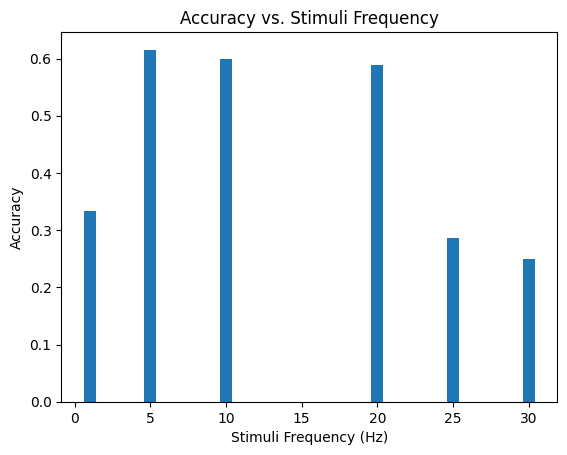

In [297]:
accuracy_1hz = KNN(sig_1hz_before_coffee_epochs, sig_1hz_after_coffee_epochs)
accuracy_5hz = KNN(sig_5hz_before_coffee_epochs, sig_5hz_after_coffee_epochs)
accuracy_10hz = KNN(sig_10hz_before_coffee_epochs, sig_10hz_after_coffee_epochs)
accuracy_15hz = KNN(sig_15hz_before_coffee_epochs, sig_15hz_after_coffee_epochs)
accuracy_20hz = KNN(sig_20hz_before_coffee_epochs, sig_20hz_after_coffee_epochs)
accuracy_25hz = KNN(sig_25hz_before_coffee_epochs, sig_25hz_after_coffee_epochs)
accuracy_30hz = KNN(sig_30hz_before_coffee_epochs, sig_30hz_after_coffee_epochs)

# plot results
x = [1, 5, 10, 15, 20, 25, 30]
y = [accuracy_1hz, accuracy_5hz, accuracy_10hz, accuracy_15hz, accuracy_20hz, accuracy_25hz, accuracy_30hz]
mean_acc = np.mean(y)
print("Mean accuracy: ", mean_acc)
plt.bar(x, y)
plt.xlabel("Stimuli Frequency (Hz)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Stimuli Frequency")
plt.show()

In [143]:
import torch
import torch.nn as nn
device = (
    "cuda:0"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

if torch.cuda.is_available():
    # Create a tensor on CPU
    tensor = torch.Tensor([1])
    print("Tensor on CPU:", tensor)

    # Move the tensor to GPU
    tensor = tensor.to('cuda')
    print("Tensor on GPU:", tensor)

    # Check if the tensor is on GPU
    if tensor.is_cuda:
        print("CUDA is using the GPU.")
    else:
        print("CUDA is using the CPU.")
else:
    print("CUDA is not available.")

Using cpu device
Is CUDA supported by this system? True
CUDA version: 11.7
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce GTX 1650
Tensor on CPU: tensor([1.])
Tensor on GPU: tensor([1.], device='cuda:0')
CUDA is using the GPU.


In [144]:
class myLSTM(nn.Module):
  def __init__(self, input_size=1, hidden_size=50, out_size=1):
    super().__init__()
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size, hidden_size )
    self.linear = nn.Linear(hidden_size, out_size)
    self.hidden = (torch.zeros(1,1,hidden_size ) , torch.zeros(1,1,hidden_size)  )
 
  def forward(self, seq):
    lstm_out, self.hidden = self.lstm(seq.view( len(seq),1,-1 ), self.hidden )
    pred = self.linear(lstm_out.view(  len(seq) ,-1 ))  
    return pred[-1]

In [145]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y).long()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

dataset = CustomDataset(X, Y)
# data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


NameError: name 'Y' is not defined

In [ ]:
test_size = 20
train_set = Y[:-test_size]
test_set = Y[-test_size:]

In [ ]:
def input_data(seq, ws):
  output = []   
  L = len(seq)
  for i in range((L) - ws):
    window = seq[i:i+ws]
    label = seq[i+ws:i+ws+1]
    print(i)
    output.append((window, label))
 
  return output

In [ ]:
window_size = 64
train_data = input_data(train_set, window_size)

In [ ]:
input_size = 616
hidden_size = 128
num_layers = 2
num_classes = 2
batch_size = 16
epochs = 50
learning_rate = 0.001

model = myLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
print(model)

myLSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


In [ ]:
for p in model.parameters():
  print(p.numel())


200
10000
200
200
50
1


In [ ]:
epochs = 10
future = 40
for i in range(epochs):
  for seq, y_train in train_data:
    optimizer.zero_grad()
    model.hidden = (torch.zeros(1,1,model.hidden_size) ,
                    torch.zeros(1,1,model.hidden_size))
    
    y_pred = model(seq)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
 
  print(f"Epoch {i} Loss {loss.item()} ")
  preds = train_set[-window_size:].tolist()
 
  for f in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
      model.hidden = (torch.zeros(1,1,model.hidden_size) ,
                      torch.zeros(1,1,model.hidden_size))
      preds.append(model(seq).item())
 
  loss = criterion(torch.tensor(preds[-window_size :]), y[760:] )
  print(f'Performance on test range: {loss}')

NameError: name 'loss' is not defined

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class EEGNET(nn.Module):
    def __init__(self, receptive_field=64, mean_pool=5, filter_sizing, dropout, D):
        super(EEGNET,self).__init__()
        channel_amount = 8
        num_classes = 3
        self.temporal=nn.Sequential(
            nn.Conv2d(1,filter_sizing,kernel_size=[1,receptive_field],stride=1, bias=False, padding='same'), 
            nn.BatchNorm2d(filter_sizing)
        )
        self.spatial=nn.Sequential(
            nn.Conv2d(filter_sizing,filter_sizing*D,kernel_size=[channel_amount,1],bias=False, groups=filter_sizing),
            nn.BatchNorm2d(filter_sizing*D),
            nn.ELU(True)
        )

        self.seperable=nn.Sequential(
            nn.Conv2d(filter_sizing*D,filter_sizing*D,kernel_size=[1,16], padding='same',groups=filter_sizing*D, bias=False),
            nn.Conv2d(filter_sizing*D,filter_sizing*D,kernel_size=[1,1], padding='same',groups=1, bias=False),
            nn.BatchNorm2d(filter_sizing*D),
            nn.ELU(True)
        )
        self.avgpool1 = nn.AvgPool2d([1, 5], stride=[1, 5], padding=0)   
        self.avgpool2 = nn.AvgPool2d([1, 5], stride=[1, 5], padding=0)
        self.dropout = nn.Dropout(dropout)
        self.view = nn.Sequential(Flatten())

        endsize = 320
        self.fc2 = nn.Linear(endsize, num_classes)

    def forward(self,x):
        out = self.temporal(x)
        out = self.spatial(out)
        out = self.avgpool1(out)
        out = self.dropout(out)
        out = self.seperable(out)
        out = self.avgpool2(out)
        out = self.dropout(out)
        out = out.view(out.size(0), -1)
        prediction = self.fc2(out)
        return prediction

SyntaxError: non-default argument follows default argument (4165255278.py, line 6)

In [ ]:
# from mne.time_frequency import psd_array_welch
# # eeg_power_band(epochs):
# freq_bands = {
#     'delta' : [0.5, 4],
#     'theta' : [4, 8],
#     'alpha' : [8, 12],  
#     'beta_low' : [12.5, 16],
#     'beta' : [16.5, 20],   
#     'beta_high' : [20.5,28],
#     'gamma' : [30, 100]
# }

# psds, freqs = psd_array_welch(signal, fmin=0.5, fmax=45, sfreq=256, n_fft=128, n_per_seg=32 )
# psds/=np.sum(psds, axis=-1, keepdims=True)
# band_arr = []
# for fmin, fmax in freq_bands.values():
#     psds_band = psds[(freqs >= fmin) & (freqs < fmax)].mean()
#     band_arr.append(psds_band)
# print( np.concatenate(band_arr, axis=1))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Load data
X_train, y_train = load_data(train=True)
X_test, y_test = load_data(train=False)

# Create dataset and dataloader
train_dataset = EEGDataset(X_train, y_train)
test_dataset = EEGDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define hyperparameters
input_size = X_train.shape[2]
hidden_size = 128
num_layers = 2
num_classes = 2
learning_rate = 0.001
num_epochs = 10

# Create LSTM classifier
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy: {:.2f}%'.format(100 * correct / total))

TypeError: get_X_Y() got an unexpected keyword argument 'train'

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM

samples = 1024
n_features = 22
time_steps = 4000

# code for building an LSTM with 100 neurons and dropout. Runs for 50 epochs

model = Sequential()
model.add(LSTM(100, return_sequences=False, input_shape=(time_steps, n_features)))
model.add(Dropout(0.5))
#model.add(LSTM(100)) dramatically worse results
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=16, epochs=50)
score = model.evaluate(x_test, y_test, batch_size=16)

Epoch 1/50


ValueError: in user code:

    File "c:\Python311\Lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "c:\Python311\Lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Python311\Lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "c:\Python311\Lib\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "c:\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Python311\Lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 4000, 22), found shape=(16, 616)


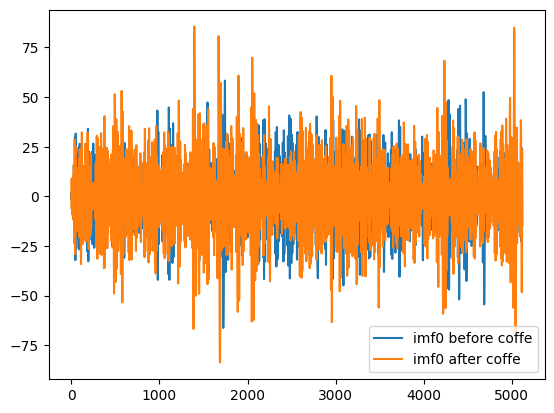

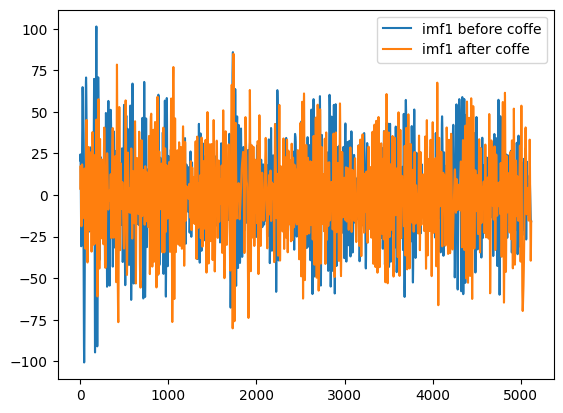

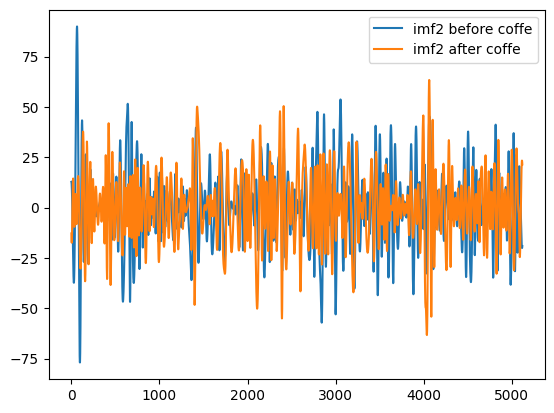

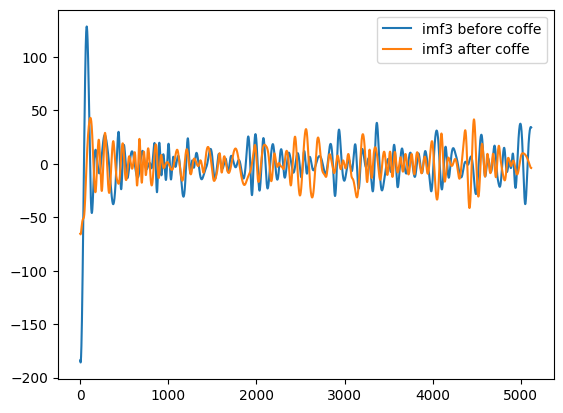

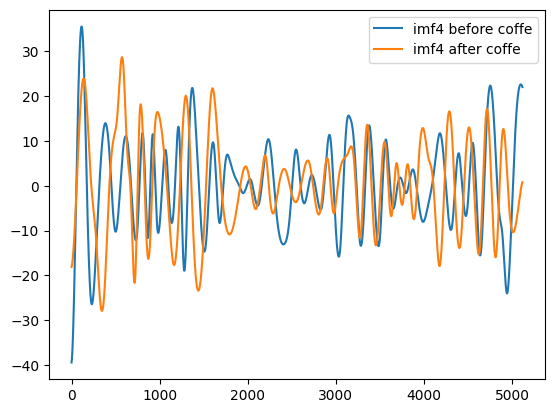

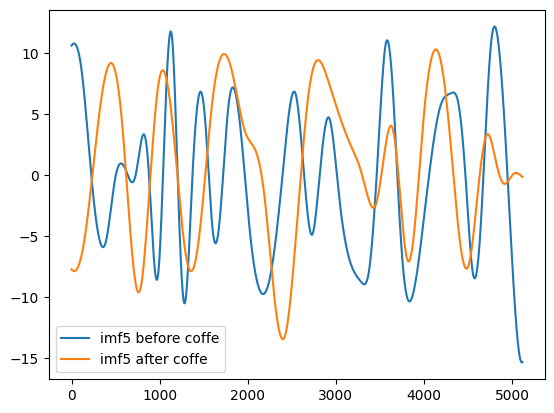

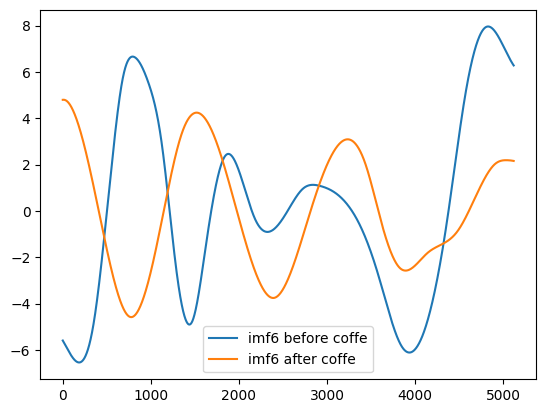

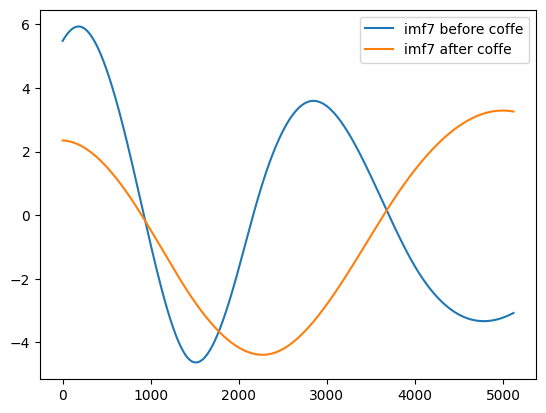

IndexError: index 8 is out of bounds for axis 0 with size 8

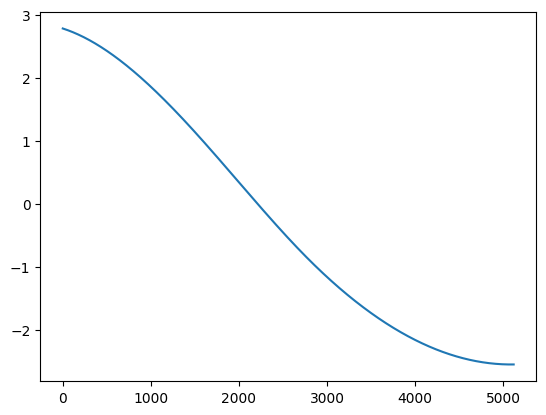

In [ ]:
# plot sig 1hz before coffee - first volunteer, first channel

data = sig_10hz_before_coffee[1][:, 0]

data2 = sig_10hz_after_coffee[1][:, 0]

# lets do empirical mode decomposition
emd = EMD()
imfs = emd(data)

# lets do emd for data2
emd2 = EMD()
imfs2 = emd2(data2)

# lets plot all imfs for data and data2 on the same plot to compare
for i in range(len(imfs)):
    # plot imf for data and data2
    plt.plot(imfs[i], label="imf" + str(i) + " before coffee")
    plt.plot(imfs2[i], label="imf" + str(i) + " after coffee")

    plt.legend()

    plt.show()

In [ ]:
def plot_welch(data, data2, window_seconds):
    # Define window length (4 seconds)
    sf = 256
    win = window_seconds * sf
    freqs, psd = signal.welch(data, sf, nperseg=win)
    freqs2, psd2 = signal.welch(data2, sf, nperseg=win)

    # Plot the power spectrum
    sns.set(font_scale=1.2, style='white')
    plt.figure(figsize=(8, 4))
    plt.plot(freqs, psd, color='k', lw=2)
    plt.plot(freqs2, psd2, color='r', lw=2)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power spectral density (V^2 / Hz)')
    plt.ylim([0, max(psd.max(), psd2.max()) * 1.1])
    plt.title("Welch's periodogram")
    plt.xlim([0, max(freqs.max(), freqs2.max())])
    sns.despine()

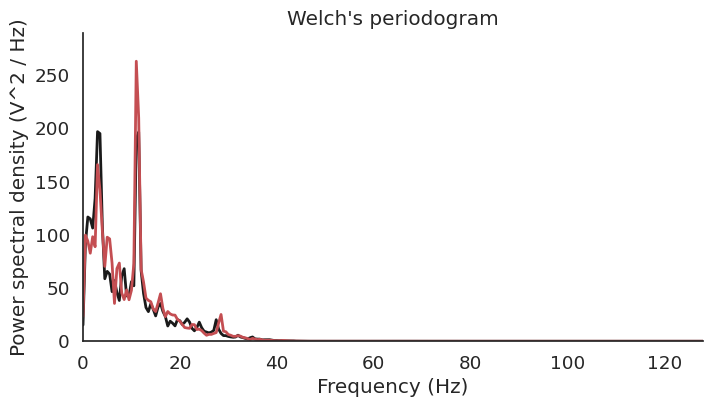

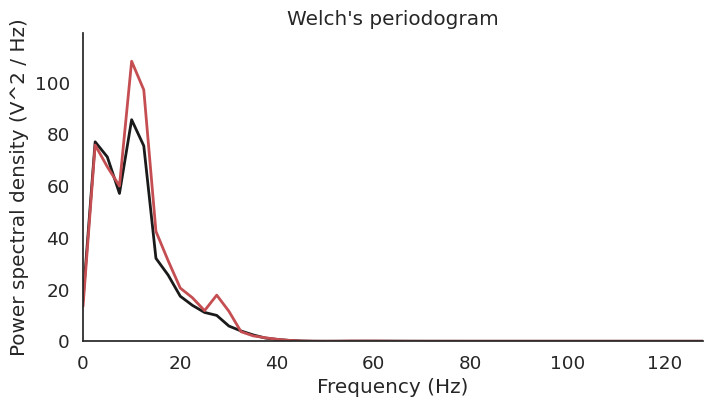

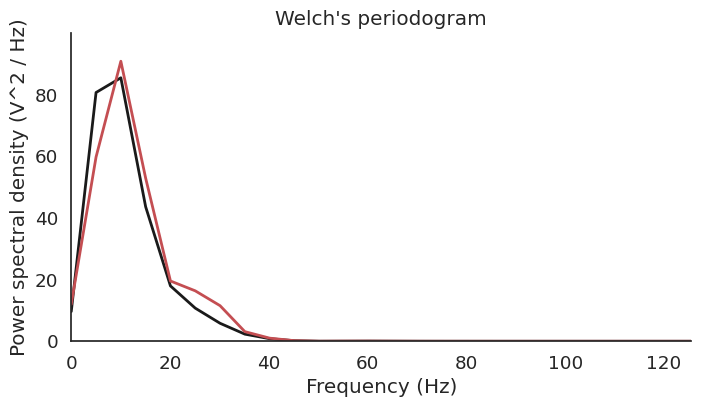

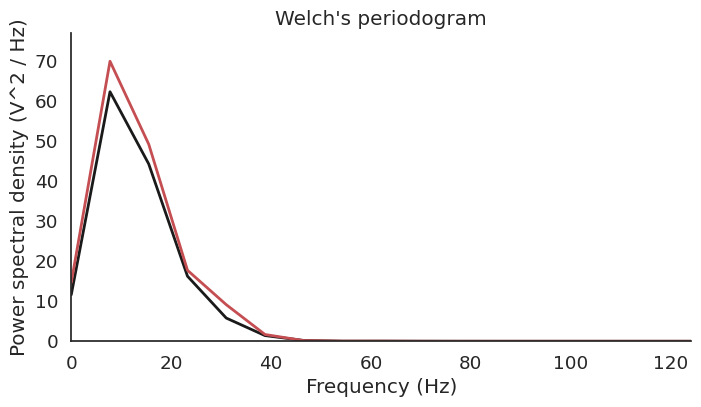

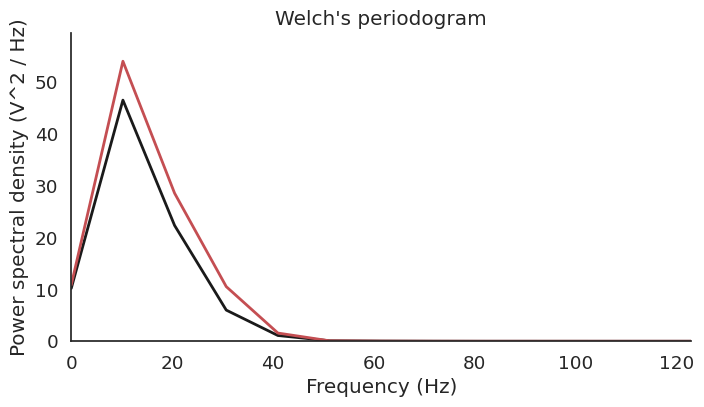

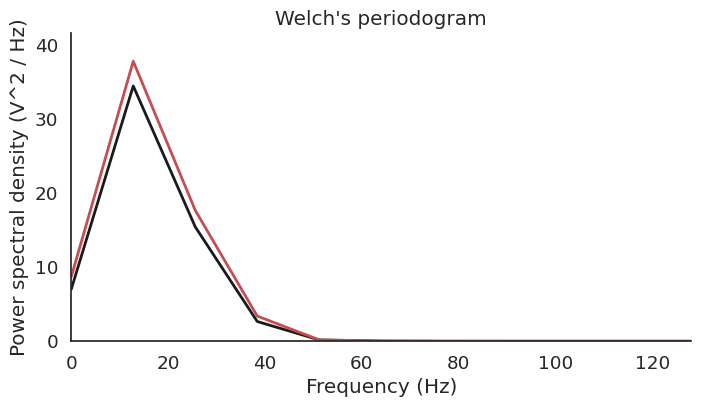

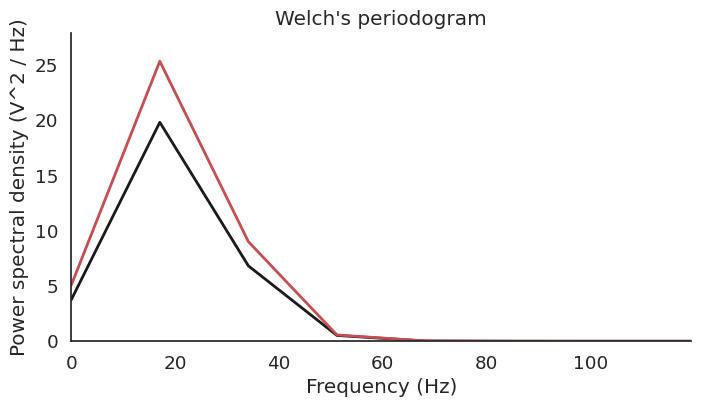

In [ ]:
data = sig_1hz_before_coffee[1][:, 0]
data2 = sig_1hz_after_coffee[1][:, 0]

# window size must be at least 2 cycles of the frquecy of interest
# 1hz = once per second so window size must be at least 2 seconds
plot_welch(data, data2, 2)



data = sig_5hz_before_coffee[1][:, 0]
data2 = sig_5hz_after_coffee[1][:, 0]

# window size must be at least 2 cycles of the frquecy of interest
# 5hz = 5 times per second so window size must be at least 0.4 seconds

plot_welch(data, data2, 0.4)


data = sig_10hz_before_coffee[1][:, 0]
data2 = sig_10hz_after_coffee[1][:, 0]

# window size must be at least 2 cycles of the frquecy of interest
# 10hz = 10 times per second so window size must be at least 0.2 seconds

plot_welch(data, data2, 0.2)


data = sig_15hz_before_coffee[1][:, 0]
data2 = sig_15hz_after_coffee[1][:, 0]

# window size must be at least 2 cycles of the frquecy of interest
# 15hz = 15 times per second so window size must be at least 0.13 seconds

plot_welch(data, data2, 0.13)


data = sig_20hz_before_coffee[1][:, 0]
data2 = sig_20hz_after_coffee[1][:, 0]

# window size must be at least 2 cycles of the frquecy of interest
# 20hz = 20 times per second so window size must be at least 0.1 seconds

plot_welch(data, data2, 0.1)


data = sig_25hz_before_coffee[1][:, 0]
data2 = sig_25hz_after_coffee[1][:, 0]

# window size must be at least 2 cycles of the frquecy of interest
# 25hz = 25 times per second so window size must be at least 0.08 seconds

plot_welch(data, data2, 0.08)


data = sig_30hz_before_coffee[1][:, 0]
data2 = sig_30hz_after_coffee[1][:, 0]

# window size must be at least 2 cycles of the frquecy of interest
# 30hz = 30 times per second so window size must be at least 0.06 seconds

plot_welch(data, data2, 0.06)


In [ ]:
# todo: calculate beta band average band power for each channel for each volunteer for each stimuli
# todo: plot results based on stimuli and channel


